### Programming Exercise 3: DCGAN for Celebrity Image Generation

#### 1. Introduction to DCGAN

##### 1.1 What is GAN?

GANs are a framework for teaching a DL model to capture the training data’s distribution so we can generate new data from that same distribution. GANs were invented by Ian Goodfellow in 2014 and first described in the paper [Generative Adversarial Nets](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf).

Let $x$ be data representing an image. $D(x)$ is the discriminator network which outputs the (scalar) probability that $x$ came from training data rather than the generator. Here, since we are dealing with images, the input to $D(x)$ is an image of $(C, H, W)$ size 3x64x64. Intuitively, $D(x)$ should be high when $x$ comes from training data and low when $x$ comes from the generator. $D(x)$ can also be thought of as a traditional binary classifier

For the generator’s notation, let $z$ be a latent space vector sampled from a standard normal distribution. $G(z)$ represents the generator function which maps the latent vector $z$ to data-space. The goal of $G$ is to estimate the distribution that the training data comes from ($p_{data}$) so it can generate fake samples from that estimated distribution ($p_{g}$). So, $D(G(z))$ is the probability (scalar) that the output of the generator G is a real image.

$D$ and $G$ play a minimax game in which $D$ tries to maximize the probability it correctly classifies reals and fakes $(\log{D(x))}$, and $G$ tries to minimize the probability that $D$ will predict its outputs are fake $(\log{(1−D(G(z)))})$. The GAN loss function is

$$\min_{G}\max_{D}V(D, G) = \mathbb{E}_{x \sim p_{data}(\bold{x})}[\log{D(x)}] + \mathbb{E}_{z \sim p_{z}(\bold{z})}[\log{(1 - D(G(\bold{z})))}]$$

In theory, the solution to this minimax game is where $p_{g}=p_{data}$, and the discriminator guesses randomly if the inputs are real or fake. However, the convergence theory of GANs is still being actively researched and in reality models do not always train to this point.

##### 1.2 What is DCGAN?

A DCGAN (Deep Convolutional Generative Adversarial Network) is a direct extension of the GAN described above, except that it uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper [Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf).

The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution.

The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, $z$, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image.

#### 2. Prepare Your Environment

Please make sure you have installed pytorch on your device. Apart from pytorch, we need the following libraries for this exercise. If you have installed them in your python environment, you can skip this step.

In [1]:
#conda install numpy
#conda install matplotlib

#### 3. Prepare Your Data

In this exercise, we will use the [Celeb-A Faces dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which has been downloaded in the folder named `data`. The Celeb-A Faces dataset is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations.  

#### 4. Coding Time

4.1 Import dependencies

In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

4.2 Set random seed for reproducibility

In [3]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


4.3 Declare parameters


- dataroot - the path to the root of the dataset folder.
- workers - the number of worker threads for loading the data with the DataLoader.
- batch_size - the batch size used in training.
- image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details.
- nc - number of color channels in the input images. For color images this is 3.
- nz - length of latent vector.
- ngf - relates to the depth of feature maps carried through the generator.
- ndf - sets the depth of feature maps propagated through the discriminator.
- num_epochs - number of training epochs to run. Training for longer will probably lead
- to better results but will also take more time.
- lr - learning rate for training.
- beta1 - beta1 hyperparameter for Adam optimizers.
- ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs.
- device - cpu or cuda. 

In [4]:
# Root directory for dataset
dataroot = "Data"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# CPU or GPU. 
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

4.4 Create the dataset and dataloader

In [5]:
dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                         shuffle = True, num_workers = workers)

4.5 Weight initialization
   
   - From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The `weights_init `function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

4.6 Define and instantiate the generator

- The generator, $G$ is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting $z$ to data-space means ultimately creating a RGB image with the same size as the training images (i.e., 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [−1,1]
. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as these layers help with the flow of gradients during training.

![Generator](images/generator.png)



In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# Instantiate the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


4.7 Define and instantiate the discriminator

- The discriminator $D$ is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.



In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

# Instantiate the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


4.8 Define Loss Functions and Optimizers

- We will use the Binary Cross Entropy loss (BCELoss) function as the loss function and Adam as the optimizer. 

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

4.9 Training

- **Train the generator**: first, we will construct a batch of real samples from the training set, forward pass through $D$, calculate the loss $log{(D(x))}$, then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through $D$, calculate the loss $log{(1−D(G(z)))}$, and accumulate the gradients with a backward pass.
- **Train the discriminator**: As stated in the original paper, we want to train the Generator by minimizing $log{(1−D(G(z)))}$. However, this was shown to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize $log{(D(G(z)))}$.




In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/2][0/792]	Loss_D: 1.9768	Loss_G: 15.1869	D(x): 0.3906	D(G(z)): 0.5253 / 0.0000
[0/2][50/792]	Loss_D: 0.1106	Loss_G: 8.5249	D(x): 0.9601	D(G(z)): 0.0077 / 0.0075
[0/2][100/792]	Loss_D: 2.8505	Loss_G: 9.3005	D(x): 0.3474	D(G(z)): 0.0003 / 0.0003
[0/2][150/792]	Loss_D: 0.5354	Loss_G: 4.9290	D(x): 0.9274	D(G(z)): 0.2295 / 0.0259
[0/2][200/792]	Loss_D: 0.4916	Loss_G: 4.0255	D(x): 0.9340	D(G(z)): 0.3013 / 0.0247
[0/2][250/792]	Loss_D: 1.1099	Loss_G: 1.1580	D(x): 0.6454	D(G(z)): 0.3777 / 0.3344
[0/2][300/792]	Loss_D: 1.0667	Loss_G: 2.1162	D(x): 0.6092	D(G(z)): 0.3750 / 0.1784
[0/2][350/792]	Loss_D: 1.0223	Loss_G: 1.4780	D(x): 0.5237	D(G(z)): 0.1961 / 0.2635
[0/2][400/792]	Loss_D: 1.2900	Loss_G: 3.6920	D(x): 0.7450	D(G(z)): 0.5587 / 0.0374
[0/2][450/792]	Loss_D: 1.3830	Loss_G: 1.3763	D(x): 0.4318	D(G(z)): 0.2804 / 0.2851
[0/2][500/792]	Loss_D: 1.0841	Loss_G: 3.0013	D(x): 0.7106	D(G(z)): 0.4240 / 0.0714
[0/2][550/792]	Loss_D: 1.2079	Loss_G: 1.8299	D(x): 0.4150	D(G(z

4.10 Visualization of the training process

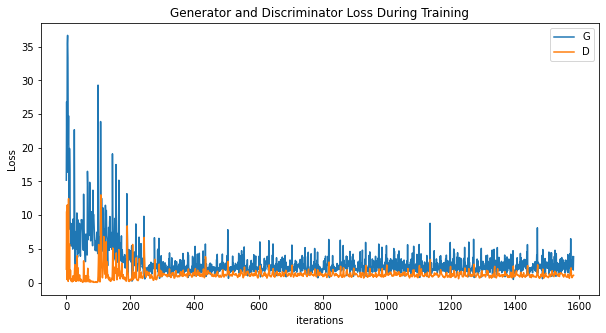

In [11]:
# Loss versus training iteration
directory = "images"
if not os.path.exists(directory):
    os.makedirs(directory)

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('images/loss.png')

4.11 Visualization of the generator's progression

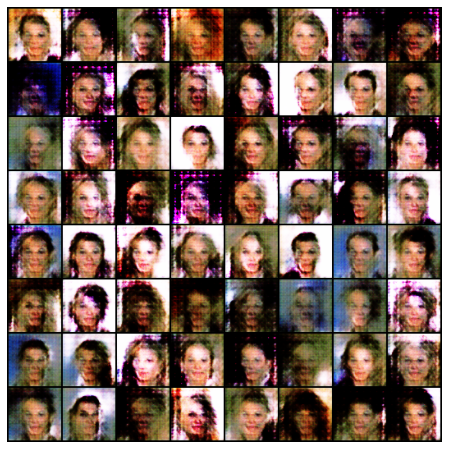

In [12]:
# Visualization of G’s progression (generate a GIF image, best view in Markdown format)

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('images/gan_progression.gif', writer='imagemagick')

4.12 Fake Images vs Real Images

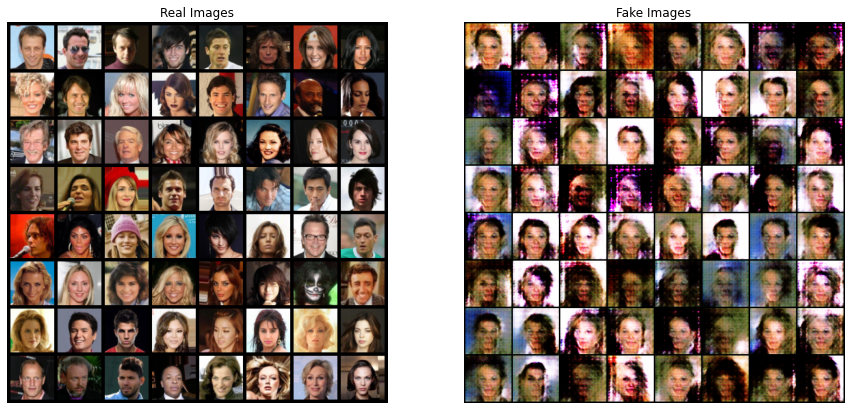

In [13]:
# Real Images vs. Fake Images

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('images/real_vs_fake.png')

#### 5. Problem Descriptions

5.1 Ordinary Questions
- **Question 1 (3 points)**: Change the random seed to generate different visualizations, analyze the impact of random seeds on visualization outcomes and evaluate the robustness of DCGANs.
- **Question 2 (3 points)**: Modify the number of epochs and discuss how results change in different epoch settings.
- **Question 3 (4 points)**: Change the learning rate and batch size and discuss the effects of these hyperparameters on the training process.

5.2 Bonus Question 

You can choose one bonus question from the following two options:
- **Bonus Question 1(3 extra points)**: Use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) to train the DCGAN model, analyze the results, and compare the performance of DCGAN on the Celeb-A Faces dataset and the MNIST dataset.
- **Bonus Question 2(Up to 5 extra points)**: [Conditional Generative Adversarial Network](https://arxiv.org/pdf/1411.1784.pdf) is a variant of GAN that conditions the model on additional information, such as class labels. Implement Conditional GAN and conduct experiments on a dataset of your choice, analyze the results, and compare the Conditional GAN with DCGAN.

#### 6. Polices
Here are some key policies that you need to obey:
- Please submit the **entire project as a zip file** to the Tsinghua Web Learning Platform. The deadline is **May 14, 2024**.
- Please solve the problems individually. If you collaborate with others, please indicate that in your submission.